In [1]:
!pip install torch torchvision feather-format kornia pyarrow --upgrade   > /dev/null
!pip install git+https://github.com/fastai/fastai_dev             > /dev/null

ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-3j0fx95c


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir
import os

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam


from tensorflow.nn import sigmoid_cross_entropy_with_logits
import tensorflow as tf

from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *

Using TensorFlow backend.


# Prepare dataframes
Load all csv files and transform them to more useful form. Identify faulty images, fix or drop them. Resample data so that we have balanced dataset + it's smaller and enables more experimentation

In [3]:
INPUT_PATH = "../input/"
RSNA_PATH = INPUT_PATH + "rsna-intracranial-hemorrhage-detection/"
train_dir = RSNA_PATH + "stage_1_train_images/"
test_dir = RSNA_PATH + "stage_1_test_images/"

In [4]:
train_df = pd.read_csv(RSNA_PATH + "stage_1_train.csv")
train_df.head(5)

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


Since the same has to be done for train and test we'll wrap the code in a nice function.

First, split ID into ID and type.
Then, transform to wide format, i.e. each subtype as separate column and 'label' as rows

In [5]:
def format_df(df):
    #step 1:
    label = df.Label.values
    df[["ID","subtype"]] = df.ID.str.rsplit("_", n=1, expand=True)
    df.drop_duplicates(['ID','subtype'], inplace=True)

    #step 2:
    df = df.pivot('ID', 'subtype', 'Label')
    df.reset_index(inplace=True)  
    return df

### Format train

In [6]:
train_df = format_df(train_df)
train_df.head(5)

subtype,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


### Format test

!!!Uncomment later

In [7]:
#test_df = pd.read_csv(INPUT_PATH + "stage_1_test.csv")
#test_df = format_df(test_df)
#test_df.head(5)

## Add metadata dataframe
From the images we can extract useful information both for processing them later but also for detecting corrupted or useless images.

1. List images in train_dir
2. Use fast.ai's function for extracting the metadata from dicom files

In [8]:
#path = Path('../input/rsna-intracranial-hemorrhage-detection/')
#path_trn = path/'stage_1_train_images'
#train_files = path_trn.ls()

#%time train_meta = pd.DataFrame.from_dicoms(train_files, px_summ=False)

META_PATH = INPUT_PATH + 'creating-a-metadata-dataframe-fastai/'
meta_train = pd.read_feather(META_PATH + 'df_trn.fth').dropna(subset=['img_pct_window'])

meta_train.head(5)

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-1024,3263,171.462490,828.102464,0.164074,NaN,NaN,NaN,NaN
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,,-125.0,1.0,1,MONOCHROME2,...,0.488281,0,2507,430.418091,599.742963,0.198139,1.0,47.0,1.0,80.0
2,ID_127689cce,CT,ID_42910d3d,ID_db93ade25b,ID_c4b4931314,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2810,12.801376,1209.046168,0.250923,NaN,NaN,NaN,NaN
3,ID_25457734a,CT,ID_329aafa7,ID_8dd6d32f3b,ID_116558f409,,-114.0,1.0,1,MONOCHROME2,...,0.445312,0,2647,566.557011,610.152845,0.298386,1.0,36.0,1.0,80.0
4,ID_81c9aa125,CT,ID_6b544c3c,ID_2685c5d5c0,ID_f56d7bd0f9,,-115.0,1.0,1,MONOCHROME2,...,0.449219,4,1570,178.512295,358.235071,0.006176,1.0,36.0,1.0,80.0


Merge metadata with train_df

In [9]:
meta_df = meta_train.join(train_df.set_index('ID'), 'SOPInstanceUID')
meta_df.head(5)

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,...,NaN,NaN,NaN,NaN,1,0,0,0,1,0
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,,-125.0,1.0,1,MONOCHROME2,...,1.0,47.0,1.0,80.0,0,0,0,0,0,0
2,ID_127689cce,CT,ID_42910d3d,ID_db93ade25b,ID_c4b4931314,,-125.0,1.0,1,MONOCHROME2,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,ID_25457734a,CT,ID_329aafa7,ID_8dd6d32f3b,ID_116558f409,,-114.0,1.0,1,MONOCHROME2,...,1.0,36.0,1.0,80.0,0,0,0,0,0,0
4,ID_81c9aa125,CT,ID_6b544c3c,ID_2685c5d5c0,ID_f56d7bd0f9,,-115.0,1.0,1,MONOCHROME2,...,1.0,36.0,1.0,80.0,0,0,0,0,0,0


## Problematic images
There are some unsigned images that have unexpected values of RescaleIntercept. Let's find these and try to fix them.

In [10]:
df1 = meta_train.query('(BitsStored==12) & (PixelRepresentation==0)') #here are the problems
df2 = meta_train.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = meta_train.query('BitsStored==16')
dfs = L(df1,df2,df3)

Get the images with strange intercept values and look at them.

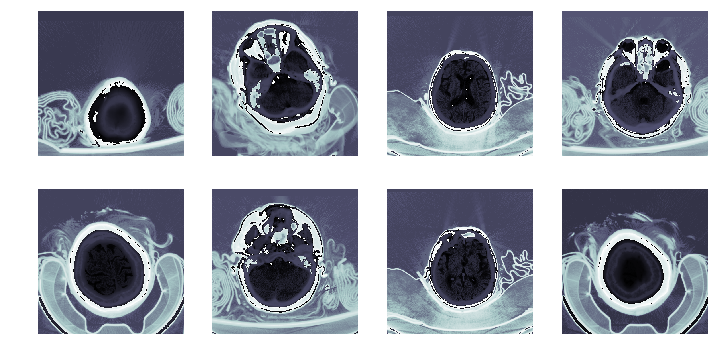

In [11]:
def df2dcm(df): return L(Path(o).dcmread() for o in df.fname.values)

strange = df1[df1.RescaleIntercept>-100]
strange_imgs = df2dcm(strange)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): strange_imgs[i].show(ax=ax)

Let's fix them now. First, shift all values by 1000. Then move values above 2000 to right place

In [12]:
def fix_img(dcm):
    if dcm.PixelRepresentation != 0 and dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

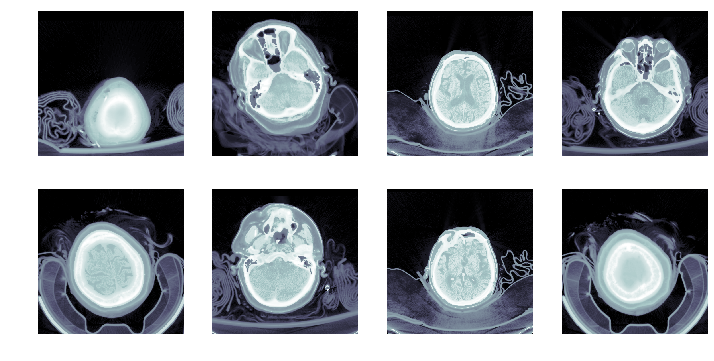

In [13]:
dcms = df2dcm(strange)
dcms.map(fix_img)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

We can pass the fix_img function to the preprocessor to fix the images if neccessary.

# Drop images with no brain
Some images contain very little brain matter. This might be because the patient moved or the image is slice above/below the brain or some unpredictable error in the imaging process.
The info about the brain pixels are stored in the meta_df as image_pct_window. 
First, we look at the distribution of these values.
Then we summarize them by class any (whether they show hemorrhage or not).

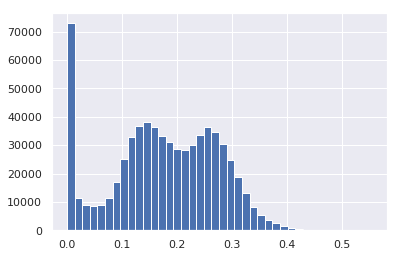

In [14]:
plt.hist(meta_df.img_pct_window,40);

In [15]:
meta_df = meta_df.assign(pct_cut = pd.cut(meta_df.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
meta_df.pivot_table(values='any', index='pct_cut', aggfunc=['sum','count']).T

,pct_cut,"(0.0, 0.02]","(0.02, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 1.0]"
sum,any,61,696,3312,21137,55437,16459
count,any,70673,19706,45886,241859,226345,61798


Let's remove the images with less than 2% of brain as they're unlikely to help the model to predict anything brain related.

In [16]:
meta_df.drop(meta_df.query('img_pct_window<0.02').index, inplace=True)
meta_df.shape

(595594, 49)

# Handling class imbalance
There's huge imbalance between healthy and hemorrhage images. Since the dataset is quite large, we'll simply downsample the healthy images to the same amount as the hemorrhage.

In [17]:
any_1 = meta_df.query('any==True')
size_any_1 = len(any_1)
size_any_1

97041

Randomly sample from the healthy images the same amount as any=1 images.

In [18]:
any_0 = meta_df.query('any==False').sample(size_any_1)
len(any_0)

97041

Merge the images together.

In [19]:
train_balance = pd.concat([any_1,any_0])
len(train_balance)

194082

# Zoom in on the brain
We're not really interested in the image areas that aren't the patient's head. So we'll crop the images so that the uninteresting areas are minimal.

We'll start with just one image to show the process and generate some images for the paper to illustrate the workflow.

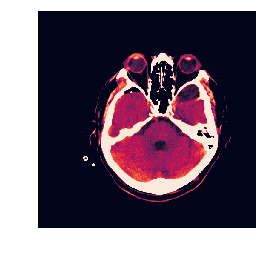

In [20]:
zoom_test = dcms[3]

zoom_window = zoom_test.windowed(*dicom_windows.brain)
show_image(zoom_window);

Blur the image to get the approximate shape of the head without the thin shapes around it

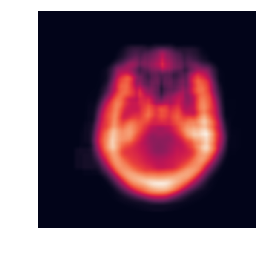

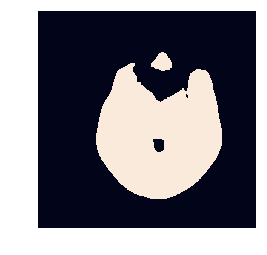

In [21]:
blurred = gauss_blur2d(zoom_window, 100)
show_image(blurred);
show_image(blurred>0.3);

We create a mask from the high contract shape showed above and plot it over the original image.

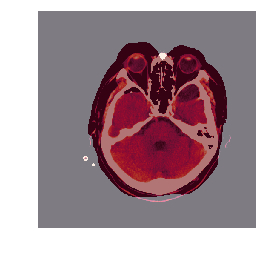

In [22]:
mask = zoom_test.mask_from_blur(dicom_windows.brain)

_,ax = subplots(1,1)
show_image(zoom_window, ax=ax[0])
show_image(mask, alpha=0.5, cmap=plt.cm.Reds, ax=ax[0]);

Now we can use this mask to crop the image and pad it to a square in case it's not a square anymore. We just find the pixels at the borders of the mask and draw a rectangle (ideally square) around them.

In [23]:
def pad_to_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(x):
    mask = x.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo,hi = bb
    cropped = x.pixel_array[lo[0]:hi[0],lo[1]:hi[1]]
    x.pixel_array = pad_to_square(cropped)

Test it on our testing image.

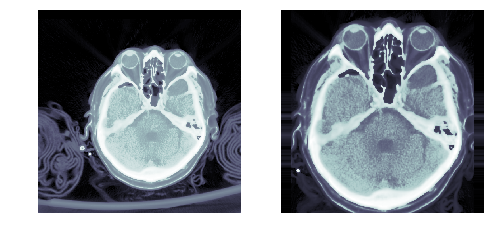

In [24]:
_,axs = subplots(1,2)
zoom_test.show(ax=axs[0])
crop_mask(zoom_test)
zoom_test.show(ax=axs[1]);

# Windows as channels and sigmoid variation enhancement
Extract 3 windows of the image, brain, bone and subdural and save them as channels of image. Each channel is represented as one color.
With sigmoid function we can increase the variation around the center of the window and keep it very low at the border values.

Images preprocessed in this way will be used for first part of the experiment.

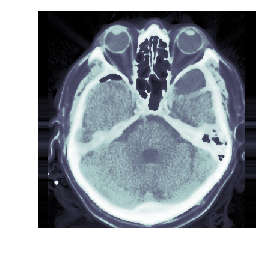

In [25]:
#use the cropped image as testing
channels = zoom_test
channels.show()

In [26]:
def to_hounsfield(dicom):
    #rescale the image to hounsfield units
    intercept = dicom[('0028','1052')].value
    slope = dicom[('0028','1053')].value
    img = dicom.pixel_array * slope + intercept
    return img
    
def sigmoid_enhance(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def to_channels(img):
    img = to_hounsfield(img)
    brain_img = sigmoid_enhance(img, 40, 80)
    subdural_img = sigmoid_enhance(img, 80, 200)
    bone_img = sigmoid_enhance(img, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

Look at the output and check the separate channels if they show just the correct windows

Text(0.5, 1.0, 'Bone')

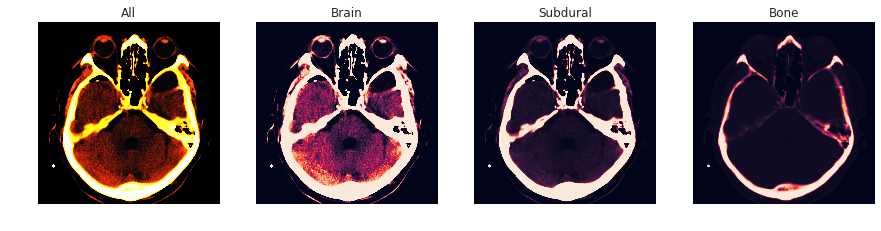

In [27]:
channels = to_channels(channels)

_, axs = plt.subplots(1, 4, figsize=(15,5))
axs[0].imshow(channels) 
axs[0].axis('off')
axs[0].set_title("All")
axs[1].imshow(channels[:,:,0]) 
axs[1].axis('off')
axs[1].set_title("Brain")
axs[2].imshow(channels[:,:,1]) 
axs[2].axis('off')
axs[2].set_title("Subdural")
axs[3].imshow(channels[:,:,2]) 
axs[3].axis('off')
axs[3].set_title("Bone")